# Testing HOG process on Tufts Walkway Scene 

In [1]:
# Demo test scene: Sidewalk near JCC building at Tufts University 
# Behind baseball field 
# Structure-from-Motion solution provided by COLMAP 
# Colmap generated: images, 3D points, cameras

import open3d as o3d
import numpy as np
import plotly.graph_objects as go 
from scipy.spatial.transform import Rotation as R
from colmapParsingUtils import *
import copy

from ptCloudParsingUtils import *


from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.pyplot as plt

import tensorflow as tf
import cv2

%load_ext autoreload
%autoreload 2
%autosave 180


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-10-10 12:24:15.929453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 12:24:15.938760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 12:24:15.949639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 12:24:15.952935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 12:24:15.961246: I tensorflow/core/platform/cpu_feature_guar

Autosaving every 180 seconds


## Step 1: Preprocessing

In [17]:
# Import in images 
# Load the image
im_c = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_colm_ss.png')
im_g = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_ge_ss.png')

print(im_c.shape)
print(im_g.shape)
# Specify the desired dimensions to crop specific pictures 
width_s = 250
width_e = width_s + 250 # desired width in pixels
height_s = 50
height_e = height_s + 500  # desired height in pixels

print('The selected pixel ratio is', width_e-width_s, 'x', height_e-height_s)

# Crop the image 
im_c_crop = im_c[height_s:height_e, width_s:width_e] #, height_s:height_e]
im_g_crop = im_g[height_s:height_e, width_s:width_e] #, height_s:height_e]

print(im_c_crop.shape)
print(im_g_crop.shape)


# RESIZE the image to 64x128
width_n = 64
height_n = 128
new_dim = (width_n, height_n)

im_c_fin = cv2.resize(im_c_crop, new_dim)
im_g_fin = cv2.resize(im_g_crop, new_dim)

print(im_c_fin.shape)
print(im_g_fin.shape)

# # Save the resized image
# cv2.imwrite('/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_colm_crop.png', im_c_crop)
# cv2.imwrite('/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_ge_crop.png', im_g_crop)
# cv2.imwrite('/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_colm_resized.png', im_c_fin)
# cv2.imwrite('/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_ge_resized.png', im_g_fin)

# Optionally, display the resized image
# Can do with opencv, don't need open3d
cv2.imshow('Colmap image', im_c_crop)
cv2.imshow('Google earth image', im_g_crop)
cv2.imshow('Colmap image resized', im_c_fin)
cv2.imshow('Google earth image resized', im_g_fin)

cv2.waitKey(0)
cv2.destroyAllWindows()


(584, 686, 3)
(584, 686, 3)
The selected pixel ratio is 250 x 500
(500, 250, 3)
(500, 250, 3)
(128, 64, 3)
(128, 64, 3)


Google earth location

https://earth.google.com/web/@42.40746735,-71.1162484,17.47625923a,0d,15y,150.37864206h,86.17713058t,0r/data=CgRCAggBIhoKFkN6SzJDT2lPMUpuaElDNnlXYXBmTncQAjoDCgEwSg0I____________ARAA

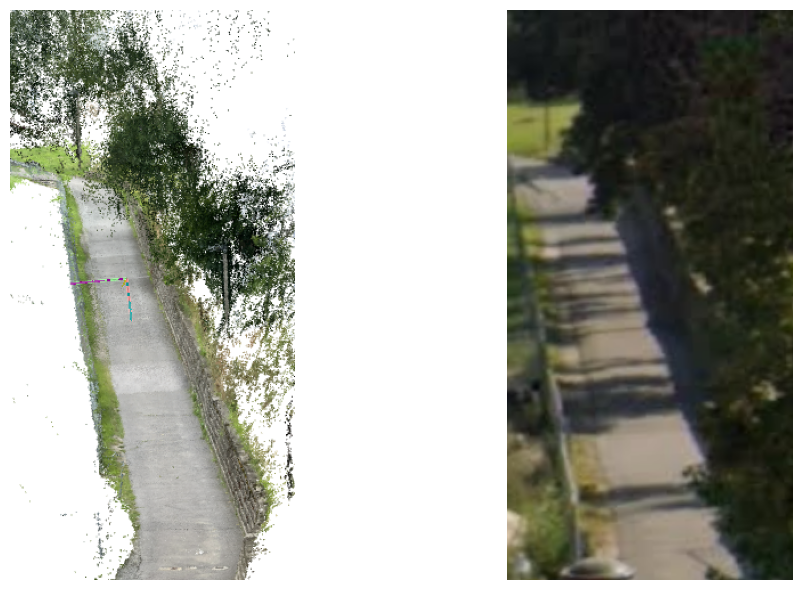

In [22]:
# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
imc = cv2.cvtColor(im_c_crop, cv2.COLOR_BGR2RGB)
plt.imshow(imc)
plt.axis("off")

plt.subplot(1, 2, 2)
imge = cv2.cvtColor(im_g_crop, cv2.COLOR_BGR2RGB)
plt.imshow(imge)
plt.axis("off")

plt.tight_layout()
plt.show()

## Step 2: Calculate Gradient Images 

In [26]:
# Choose specific image 
image_fnc = "/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_colm_resized.png"
image_fnge = "/home/daniel-choate/ASAR/s2/TerrainNav/Photo_tests/tuftsww_ge_resized.png"

imc = cv2.imread(image_fnc)
imge = cv2.imread(image_fnge)

imc = np.float32(imc) / 255.0
imge = np.float32(imge) / 255.0

imc = cv2.cvtColor(imc, cv2.COLOR_BGR2RGB) # Open CV uses BGR??
imge = cv2.cvtColor(imge, cv2.COLOR_BGR2RGB) # Open CV uses BGR??

print(imc.shape)
print(imge.shape)

# Calculate gradient
gx_c = cv2.Sobel(imc, cv2.CV_32F, 1, 0, ksize=1)
gy_c = cv2.Sobel(imc, cv2.CV_32F, 0, 1, ksize=1)

gx_ge = cv2.Sobel(imge, cv2.CV_32F, 1, 0, ksize=1)
gy_ge = cv2.Sobel(imge, cv2.CV_32F, 0, 1, ksize=1)

print(gx_c.shape)
print(gx_ge.shape)

# print("\n Gradients in the x-direction, colm \n", gx_c)
# print("\n Gradients in the y-direction, colm \n", gy_c)
# print("\n Gradients in the x-direction, ge \n", gx_ge)
# print("\n Gradients in the y-direction, ge \n", gy_ge)


# Calculate gradient magnitude and direction ( in degrees )
mag_c, angle_c = cv2.cartToPolar(gx_c, gy_c, angleInDegrees=True)
mag_ge, angle_ge = cv2.cartToPolar(gx_ge, gy_ge, angleInDegrees=True)


# Make ALL ANGLES within 180 degrees 
angle_c[angle_c > 180] -= 180
angle_ge[angle_ge > 180] -= 180

print(mag_c.shape)
print(mag_ge.shape)

print("\n Angles colm \n", angle_c)
print("\n Angles ge \n", angle_ge)

(128, 64, 3)
(128, 64, 3)
(128, 64, 3)
(128, 64, 3)
(128, 64, 3)
(128, 64, 3)

 Angles colm 
 [[[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]]

 [[ 90.        90.        90.      ]
  [147.99973  147.99973  131.99557 ]
  [ 99.60492   99.461975 102.33978 ]
  ...
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]]

 [[ 90.        90.        90.      ]
  [159.58578  157.68939  158.58258 ]
  [ 18.85704   19.751007  30.960068]
  ...
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]]

 ...

 [[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0. 

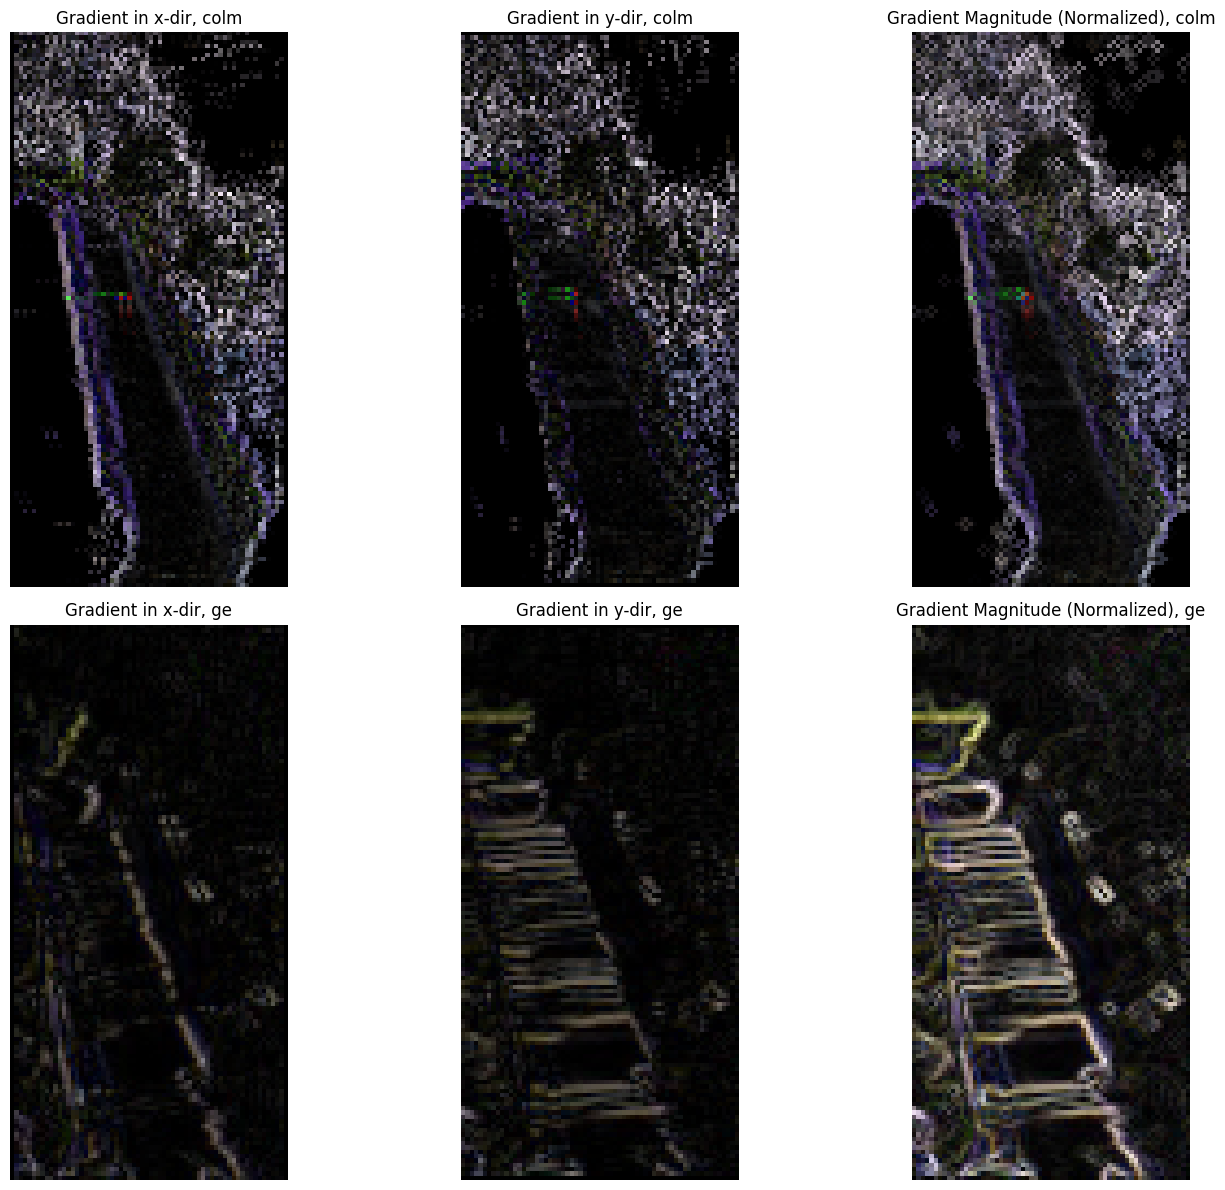

In [31]:
# Plot image gradients 

plt.figure(figsize=(15, 12))

# COLMAP 
# Plot gradient magnitude in x
plt.subplot(2, 3, 1)
plt.imshow(np.abs(gx_c))#, cmap='gray')
plt.title('Gradient in x-dir, colm')
plt.axis('off')

# Plot gradient magnitude in y
plt.subplot(2, 3, 2)
plt.imshow(np.abs(gy_c))#, cmap="gray")
plt.title('Gradient in y-dir, colm')
plt.axis("off")

# Plot gradient magnitude normalized
plt.subplot(2, 3, 3)
magnitude_normalized_c = cv2.normalize(mag_c, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(magnitude_normalized_c)#, cmap='gray')
plt.title('Gradient Magnitude (Normalized), colm')
plt.axis('off')

# GOOGLE EARTH

# Plot gradient magnitude in x
plt.subplot(2, 3, 4)
plt.imshow(np.abs(gx_ge))#, cmap='gray')
plt.title('Gradient in x-dir, ge')
plt.axis('off')

# Plot gradient magnitude in y
plt.subplot(2, 3, 5)
plt.imshow(np.abs(gy_ge))#, cmap="gray")
plt.title('Gradient in y-dir, ge')
plt.axis("off")

# Plot gradient magnitude normalized
plt.subplot(2, 3, 6)
magnitude_normalized_ge = cv2.normalize(mag_ge, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(magnitude_normalized_ge)#, cmap='gray')
plt.title('Gradient Magnitude (Normalized), ge')
plt.axis('off')

plt.tight_layout()
plt.show()

# print("OG MAG \n", mag)
# print("\n DIF MAG \n", magnitude_normalized)

## Step 3: Divide Image into 8x8 cells